In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

import plotly.graph_objects as go
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.models import load_model

import pathlib
import matplotlib.pyplot as plt

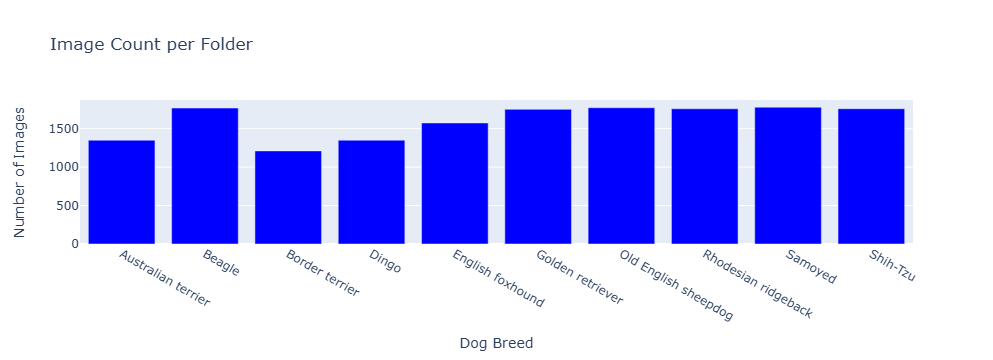

In [3]:

# lbl_dict = dict(
#   n02093754='Australian terrier', 
#   n02089973='Border terrier', 
#   n02099601='Samoyed', 
#   n02087394='Beagle', 
#   n02105641='Shih-Tzu', 
#   n02096294='English foxhound', 
#   n02088364='Rhodesian ridgeback', 
#   n02115641='Dingo', 
#   n02111889='Golden retriever', 
#   n02086240='Old English sheepdog'
# )
data_dir = pathlib.Path('dataset')
image_count = len(list(data_dir.glob('*/*.jpg')))

folders = os.listdir('dataset')
image_counts = []
random_images = []

for folder in folders:
    folder_path = os.path.join('dataset', folder)
    if os.path.isdir(folder_path):
        images = [img for img in os.listdir(folder_path) if img.lower().endswith(('png', 'jpg', 'jpeg'))]
        image_counts.append(len(images))

fig = go.Figure([go.Bar(x=folders, y=image_counts, marker_color='blue')])
fig.update_layout(title='Image Count per Folder', xaxis_title='Dog Breed', yaxis_title='Number of Images')
fig.show()


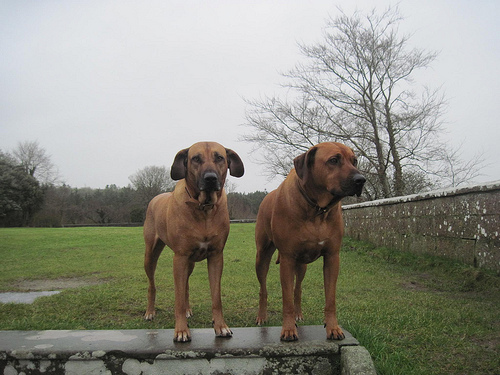

In [4]:
beagles = list(data_dir.glob('Beagle/*'))
PIL.Image.open(str(beagles[4]))


In [5]:
batch_size = 32
img_height = 224
img_width = 224

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 16072 files belonging to 10 classes.
Using 12858 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 16072 files belonging to 10 classes.
Using 3214 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)


['Australian terrier', 'Beagle', 'Border terrier', 'Dingo', 'English foxhound', 'Golden retriever', 'Old English sheepdog', 'Rhodesian ridgeback', 'Samoyed', 'Shih-Tzu']


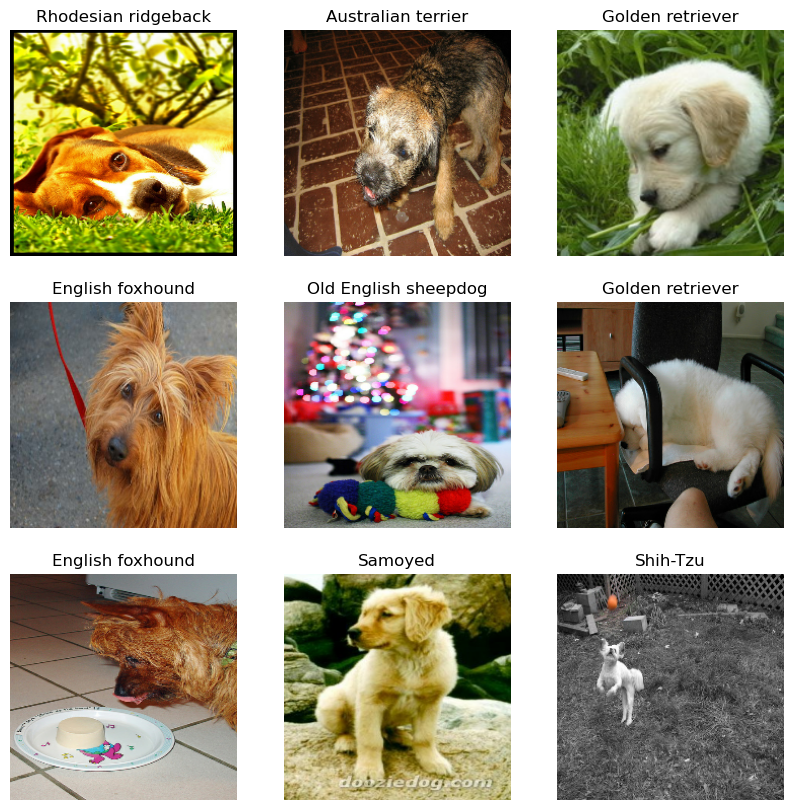

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [10]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32,)


In [11]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [12]:
normalization_layer = layers.Rescaling(1./255)


normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0020633303 1.0


In [13]:
num_classes = len(class_names)

model = Sequential([
    Input(shape=(224, 224, 3)),

    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  
    
    Dense(256, activation='relu'),
    Dropout(0.3),  
    
    Dense(10, activation='softmax')
])


In [14]:
model.trainable = True

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])



In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,529,994 (169.87 MB)

 Trainable params: 44,529,994 (169.87 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 277s 672ms/step - accuracy: 0.1075 - loss: 13.8066 - val_accuracy: 0.1098 - val_loss: 2.3005
Epoch 2/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 268s 667ms/step - accuracy: 0.1083 - loss: 2.2999 - val_accuracy: 0.1098 - val_loss: 2.2989
Epoch 3/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 279s 695ms/step - accuracy: 0.1054 - loss: 2.2985 - val_accuracy: 0.1095 - val_loss: 2.2975
Epoch 4/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 268s 666ms/step - accuracy: 0.1090 - loss: 2.2997 - val_accuracy: 0.1095 - val_loss: 2.2963
Epoch 5/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 270s 672ms/step - accuracy: 0.1049 - loss: 2.2966 - val_accuracy: 0.1098 - val_loss: 2.2956
Epoch 6/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 271s 675ms/step - accuracy: 0.1026 - loss: 2.2963 - val_accuracy: 0.1098 - val_loss: 2.2951
Epoch 7/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 278s 691ms/step - accuracy: 0.1125 - loss: 2.2950 - val_accuracy: 0.1098 - val_loss: 2.2949
Epoch 8/15
402/402 ━━━━━━━━━━━━━━━━━━━━ 272s 676ms/step - accuracy: 0.1082 

KeyboardInterrupt: 

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


NameError: name 'history' is not defined

In [ ]:

model.save("test3.keras")

In [24]:
model = load_model("test2.keras")

def predict_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize
    img_array = image.img_to_array(img) / 255.0  # Normalize (0-1)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    prediction = model.predict(img_array)
    print(prediction)
    predicted_class = np.argmax(prediction)
    confidence = prediction[0][predicted_class]

    print(f"Predicted breed: {class_names[predicted_class]} ({confidence:.2f})")




test_dir = pathlib.Path('test-images')
paths = list(test_dir.glob('*.jpg'))

for i, path in enumerate(paths):
    print(path)
    predict_image(path)

test-images\car.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
[[0.01465141 0.1281913  0.04587584 0.05584881 0.05388058 0.08792209
  0.22610994 0.13031903 0.07742055 0.17978056]]
Predicted breed: Old English sheepdog (0.23)
test-images\lab.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[0.01570018 0.12912937 0.04420666 0.05771811 0.05493502 0.09350593
  0.22077659 0.1307124  0.0808915  0.17242421]]
Predicted breed: Old English sheepdog (0.22)
test-images\labrador.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
[[0.01422492 0.12737514 0.04036429 0.05287672 0.05282061 0.09427308
  0.22604068 0.13513568 0.08073347 0.17615545]]
Predicted breed: Old English sheepdog (0.23)
test-images\remote.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
[[0.0174386  0.12758541 0.04651708 0.06134897 0.05655    0.09384105
  0.21627145 0.12755615 0.08190975 0.17098159]]
Predicted breed: Old English sheepdog (0.22)
test-images\seal.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
[[0.01889487 0.13315833 0.04581584 0.0611917  0.0530105 